In [1]:
import os 
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
os.environ['PYTHONHASHSEED'] = '0'

In [2]:
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'
symbol = 'EUR_USD'
raw = pd.read_csv(url,index_col = 0, parse_dates = True)
raw.head()

,HIGH,LOW,OPEN,CLOSE
Date,,,,
2019-10-01 00:00:00,1.0899,1.0897,1.0897,1.0899
2019-10-01 00:01:00,1.0899,1.0896,1.0899,1.0898
2019-10-01 00:02:00,1.0898,1.0896,1.0898,1.0896
2019-10-01 00:03:00,1.0898,1.0896,1.0897,1.0898
2019-10-01 00:04:00,1.0898,1.0896,1.0897,1.0898


In [3]:
data = pd.DataFrame(raw['CLOSE'].loc[:])
print(data.columns)
data.columns = [symbol]

Index(['CLOSE'], dtype='object')


In [4]:
#data = data.resample('1h',label = 'right').last().ffill()

In [5]:
data = data.resample('1h',label = 'right').last().ffill()


<AxesSubplot:xlabel='Date'>

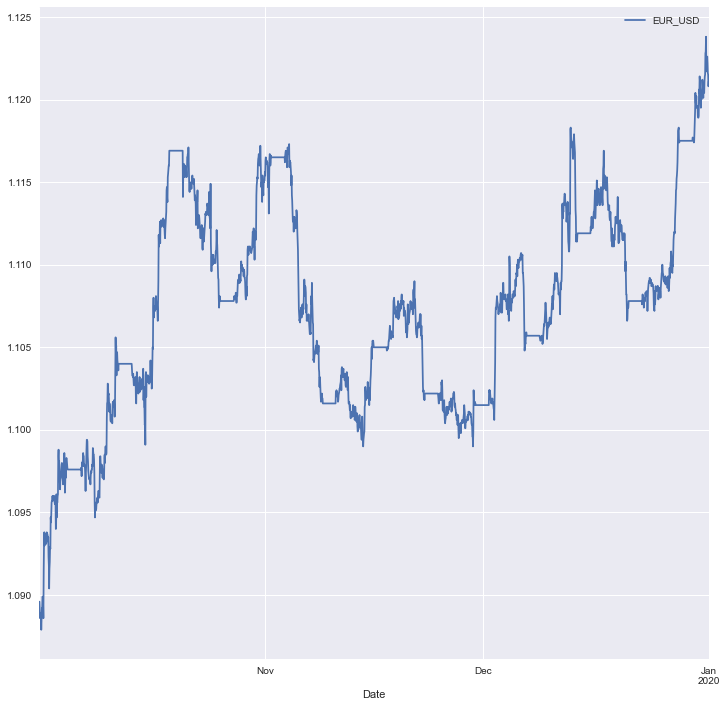

In [6]:
data.plot(figsize=(12,12))

In [7]:
lags = 5;
def add_lags(data, symbol, lags, window=20): 
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift())
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std() 
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol'] 
    for f in features:
        for lag in range(1, lags + 1): 
            col = f'{f}_lag_{lag}' 
            df[col] = df[f].shift(lag) 
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols


In [8]:
len(data/data.shift())
data, cols = add_lags(data,symbol,lags)

In [9]:
def cw(df):
    c0,c1 = np.bincount(df['d'])
    w0 = ((1/c0) * len(df))/2
    w1 = (1/c1) * len(df) / 2
    return {0:w0,1:w1}

class_weight = cw(data)
class_weight

{0: 0.755363321799308, 1: 1.4789972899728998}

In [10]:
import random 
import tensorflow as tf 
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [11]:
def set_seeds(seed = 100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
optimizer = Adam(lr = 0.001)

def create_model(hl=1,hu = 128, optimizer = optimizer):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols),
                             activation='relu'))
    for _ in range(hl):
        model.add(Dense(hu,activation = 'relu'))
    model.add(Dense(1,activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy',optimizer = optimizer, metrics = ['accuracy'])
    return model

2023-01-23 16:04:56.590563: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 16:04:56.590979: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
set_seeds()
model = create_model(hl=1,hu=128)

In [13]:
model.fit(data[cols], data['d'], epochs=50,
                   verbose=False, class_weight=cw(data))

In [14]:
model.evaluate(data[cols],data['d']) # model performance 

2183/2183 [==============================] - 0s 77us/step


[0.5853453145024976, 0.6005496978759766]

In [15]:
data['p'] = np.where(model.predict(data[cols])>0.5,1,0)
data['p'].value_counts()

1    1398
0     785
Name: p, dtype: int64

In [16]:
# out of sample performance of dnn

split = int(len(data)*0.8)
train = data.iloc[:split].copy()
test = data.iloc[split:].copy()
set_seeds()
model = create_model(hl=1,hu = 128)
model.fit(train[cols],train['d'],epochs = 50,verbose = False,validation_split = 0.2,
          shuffle = False,class_weight = cw(train))


In [17]:
model.evaluate(train[cols],train['d'])

1746/1746 [==============================] - 0s 46us/step


[0.6152685390441824, 0.575028657913208]

In [18]:
model.evaluate(test[cols],test['d']) # model performance out of sample is pretty good too 

437/437 [==============================] - 0s 66us/step


[0.5967269317509107, 0.6201372742652893]

In [19]:
test['p'] = np.where(model.predict(test[cols]) > 0.5, 1, 0)
test['p'].value_counts()

1    301
0    136
Name: p, dtype: int64

In [20]:
res = pd.DataFrame(model.history.history)

<AxesSubplot:>

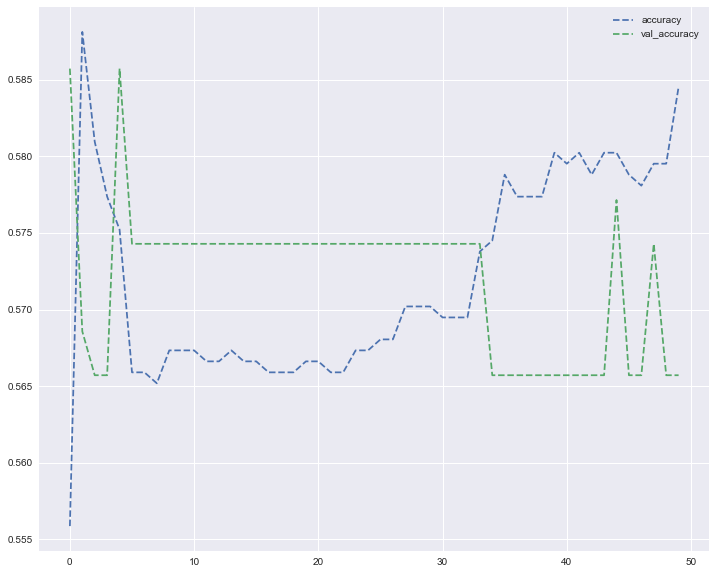

In [21]:
res[['accuracy','val_accuracy']].plot(figsize = (12,10),style = '--')

In [22]:
# there is no guarantee that out of sample performance imporves through features normalization
mu, std = train.mean(), train.std()

# normalization 
train_ = (train - mu)/std
set_seeds()
model = create_model(hl=2,hu = 128)
set_seeds()

In [23]:
model.fit(train_[cols],train['d'],
          epochs = 50, verbose = False,
          validation_split = 0.2, shuffle = False, 
          class_weight = cw(train))
          

In [24]:
model.evaluate(train_[cols],train['d'])

1746/1746 [==============================] - 0s 62us/step


[0.4664261424305922, 0.9043527841567993]

In [25]:
test_ = (test - mu) / std
model.evaluate(test_[cols],test['d'])

437/437 [==============================] - 0s 60us/step


[1.6838611378004131, 0.6475972533226013]

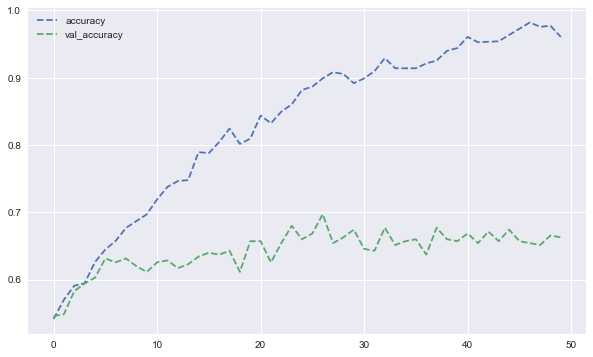

In [26]:
# training accuracy and validation accuracy 
res = pd.DataFrame(model.history.history)
res[['accuracy','val_accuracy']].plot(figsize = (10,6),style = '--');

In [27]:
#dropout adding a dropout after each layer
from keras.layers import Dropout

In [29]:
def create_model(hl = 1, hu = 128, dropout = True, rate = 0.3, 
                 optimizer = optimizer):
    model = Sequential()
    model.add(Dense(hu,input_dim = len(cols),activation = 'relu'))
    if dropout:
        model.add(Dropout(rate,seed = 100))
    for _ in range(hl):
        model.add(Dense(hu,activation = 'relu'))
        if dropout:
            model.add(Dropout(rate,seed = 100))
    model.add(Dense(1,activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy',optimizer = optimizer,
                 metrics = ['accuracy'])
    return model

In [30]:
set_seeds()
model = create_model(hl = 1, hu = 128, rate = 0.3)

In [32]:
model.fit(train_[cols], train['d'],epochs = 50, verbose = False, 
          validation_split = 0.15, shuffle = False, 
          class_weight = cw(train))

          

In [33]:
model.evaluate(train_[cols],train['d'])

1746/1746 [==============================] - 0s 48us/step


[0.4471636655882325, 0.7783505320549011]

In [34]:
model.evaluate(test_[cols],test['d'])

437/437 [==============================] - 0s 85us/step


[0.5868895978622087, 0.6453089118003845]

In [35]:
res = pd.DataFrame(model.history.history)

<AxesSubplot:>

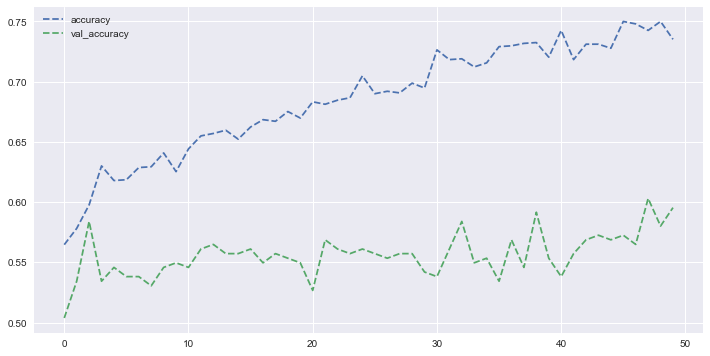

In [36]:
res[['accuracy','val_accuracy']].plot(figsize = (12,6),style = '--')

In [41]:
# regularisation if the connections in the neural network become too strong

from keras.regularizers import l1, l2 # l1 is linear norm and l2 is euclidean norm

def create_model(hl = 1,hu = 128, dropout = False, rate = 0.3, 
                 regularize = False, reg = l1(0.0005), 
                 optimizer = optimizer, input_dim = len(cols)):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hu,input_dim = input_dim,
                   activity_regularizer = reg,
                   activation = 'relu'))
    if dropout:
        model.add(Dropout(rate,seed = 100))
    for _ in range(hl):
        model.add(Dense(hu, activation = 'relu', activity_regularizer = reg))
        if dropout:
            model.add(Dropout(rate,seed = 100))
    model.add(Dense(1,activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

In [43]:
set_seeds()
model = create_model(hl = 1, hu = 128, regularize = True)

In [44]:
model.fit(train_[cols], train['d'], epochs = 50, verbose = False, 
         validation_split = 0.2, shuffle = False, 
         class_weight = cw(train))

In [45]:
model.evaluate(train_[cols], train['d']) # insample test 

1746/1746 [==============================] - 0s 43us/step


[0.48848608651658243, 0.7961053848266602]

In [46]:
model.evaluate(test_[cols],test['d'])

437/437 [==============================] - 0s 73us/step


[0.7267236750513247, 0.6567505598068237]

<AxesSubplot:>

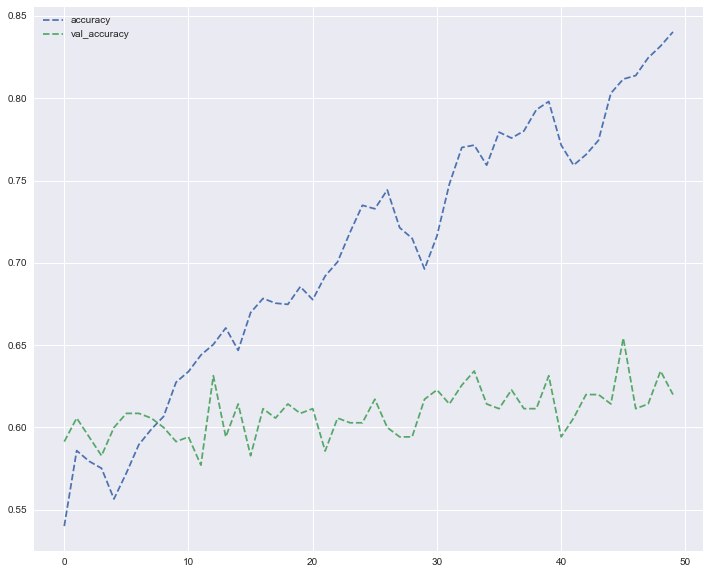

In [47]:
res = pd.DataFrame(model.history.history)
res[['accuracy','val_accuracy']].plot(figsize = (12,10),style = '--')

In [49]:
# we can use dropout and regularization as the same time

set_seeds()
model = create_model(hl=2, hu = 128, 
                    dropout = True, rate = 0.3, 
                    regularize = True, reg = l2(0.001))

In [50]:
model.fit(train_[cols], train['d'], 
         epochs = 50, verbose = False, 
         validation_split = 0.2, shuffle = False, 
         class_weight = cw(train))


In [51]:
model.evaluate(train_[cols], train['d'])

1746/1746 [==============================] - 0s 63us/step


[0.5157314297942635, 0.7537227869033813]

In [52]:
model.evaluate(test_[cols],test['d'])

437/437 [==============================] - 0s 94us/step


[0.6139559224759414, 0.6430205702781677]

<AxesSubplot:>

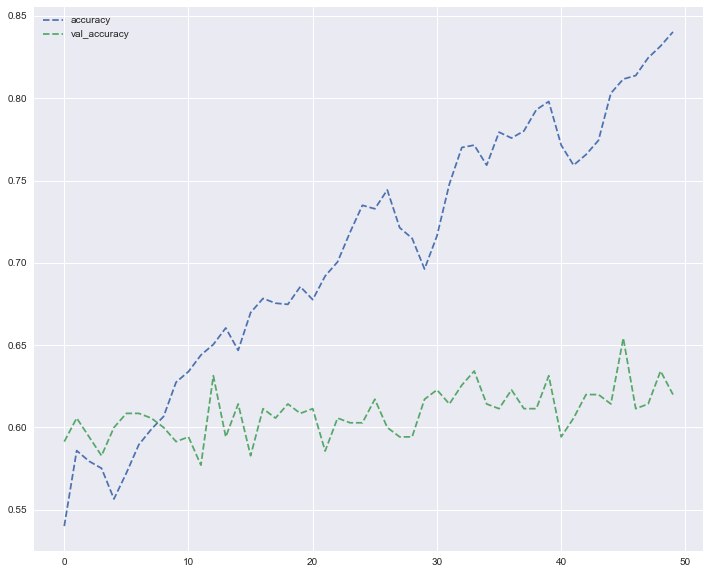

In [53]:
res[['accuracy','val_accuracy']].plot(figsize = (12,10), style = '--')

In [54]:
# regularisation penalises large weights in a neural network, 
#single weights cannot get large enough to dominate 
# the neural network




In [55]:
# Bagging 
from sklearn.ensemble import BaggingClassifier
from keras.wrappers.scikit_learn import KerasClassifier

max_features = 0.75


In [58]:
set_seeds()
base_estimator = KerasClassifier(build_fn = create_model, 
                                verbose = False, epochs = 20, hl = 1, hu = 128, 
                                dropout = True, regularize = False, 
                                input_dim = int(len(cols)*max_features))
                                 

In [63]:
model_bag = BaggingClassifier(base_estimator = base_estimator,
                              n_estimators = 15, 
                              max_samples = 0.75, 
                              max_features = max_features, 
                              bootstrap = True, 
                              bootstrap_features = True,
                              n_jobs = 1, 
                              random_state = 100,
                             )

In [66]:
%time model_bag.fit(train_[cols],train['d'])

CPU times: user 2min 35s, sys: 3min 57s, total: 6min 32s
Wall time: 1min 31s


BaggingClassifier(base_estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fea3f1dde10>,
                  bootstrap_features=True, max_features=0.75, max_samples=0.75,
                  n_estimators=15, n_jobs=1, random_state=100)

In [67]:
model_bag.score(train_[cols], train['d'])

0.7319587628865979

In [69]:
model_bag.score(test_[cols],test['d'])

0.6636155606407322

In [71]:

test['p'] = model_bag.predict(test_[cols])

In [73]:
test['p'].value_counts()

0    405
1     32
Name: p, dtype: int64

In [74]:
# bagging - certain parts of the neural netowrk only see certain 
# data and features. 

In [75]:
#optimizers ... keras has several optimizers that are used in combination with Sequential model
import time


In [89]:
optimizers = ['sgd','rmsprop','adagrad','adadelta','adam','adamax','nadam']

In [111]:
i = 0
for opimizer in optimizers:
    set_seeds()
    
    print('optimizer = ', optimizer)
    model = create_model(hl = 1, hu = 128, 
                        dropout = True, rate = 0.3, 
                        regularize = False, reg = l2(0.001), 
                        optimizer = optimizer)
    t0 = time.time()
    model.fit(train_[cols], train['d'], 
             epochs = 50, verbose = False,
             validation_split = 0.2, shuffle = False, 
             class_weight = cw(train))
    t1 = time.time()
    t = t1 - t0
    acc_tr = model.evaluate(train_[cols], train['d'], verbose = False)[1]
    acc_te = model.evaluate(test_[cols], test['d'], verbose = False)[1]
    #out = f'{time[s]: {t:.4f} | in-sample={acc_tr:.4f}' 
    #out = f'optimizer = {optimizers[i]:10s} | out-of-sample={acc_te:.4f}'
    out = f'{optimizers[i]:10s} | time[s]: {t:.4f} | in-sample={acc_tr:.4f}' 
    out += f' | out-of-sample={acc_te:.4f}'
    print(out)
    i+=1
    
    #out = f'{optimizer:10s} | time[s]: {t:.4f} | in-sample = {acc_tr:.4f}'
    #out+= f' | out-of-sample = {acc_te:4f}'

optimizer =  <keras.optimizers.Adam object at 0x7fea18b86750>
sgd        | time[s]: 12.4020 | in-sample=0.7892 | out-of-sample=0.6545
optimizer =  <keras.optimizers.Adam object at 0x7fea18b86750>
rmsprop    | time[s]: 12.1305 | in-sample=0.7892 | out-of-sample=0.6545
optimizer =  <keras.optimizers.Adam object at 0x7fea18b86750>
adagrad    | time[s]: 12.1662 | in-sample=0.7892 | out-of-sample=0.6545
optimizer =  <keras.optimizers.Adam object at 0x7fea18b86750>
adadelta   | time[s]: 12.1315 | in-sample=0.7892 | out-of-sample=0.6545
optimizer =  <keras.optimizers.Adam object at 0x7fea18b86750>
adam       | time[s]: 11.9659 | in-sample=0.7892 | out-of-sample=0.6545
optimizer =  <keras.optimizers.Adam object at 0x7fea18b86750>
adamax     | time[s]: 12.6965 | in-sample=0.7892 | out-of-sample=0.6545
optimizer =  <keras.optimizers.Adam object at 0x7fea18b86750>
nadam      | time[s]: 12.7126 | in-sample=0.7892 | out-of-sample=0.6545


In [108]:
out = f'optimizer = {optimizers[0]:1s} time = {t:.4f} | in-sample={acc_tr:.4f}' 


out += f' | out-of-sample={acc_te:.4f}'

In [106]:
a = 'ananth'
str = f'a = {a:10s}'
print(str)

a = ananth    


out
